# Handwritten-Text-Recognition with Tensorflow 2.0

### 1. Check if GPU is available:

First lets see if the jupyter notebook is using the gpu:

In [1]:
!nvidia-smi

Fri Mar  6 01:03:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  On   | 00000000:01:00.0  On |                  N/A |
| 45%   31C    P0    N/A /  75W |    302MiB /  4038MiB |     18%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Install tensorflow that supports gpu use:

In [2]:
!pip install -q tensorflow-gpu==2.1.0

In [3]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


### 2. Run the other Notebooks, import modules, set constants  :

In [4]:
%run Model.ipynb
%run DataGenerator.ipynb
%run FileTransformer.ipynb
import os
import datetime
import string

In [5]:
class FilePaths:
    iam_path = os.path.join("..","raw","iam")
    source_path = os.path.join("..", "data", "iam.hdf5")
    output_path = os.path.join("..", "output")
    target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
    model_saved_path = os.path.join("..", "output", "saved_model.h5")
    test_image_path = os.path.join("..", "data", "test.png")
    test_image_preprocessed_path = os.path.join("..", "output", "preprocessed_test.png")
    cnn_1_weights_path = os.path.join("..", "output", "cnn_weights_1.png")
    cnn_2_weights_path = os.path.join("..", "output", "cnn_weights_2.png")
    cnn_1_outputs = os.path.join("..", "output", "cnn_1_outputs.png")
    cnn_2_outputs = os.path.join("..", "output", "cnn_2_outputs.png")
    cnn_3_outputs = os.path.join("..", "output", "cnn_3_outputs.png")
    cnn_4_outputs = os.path.join("..", "output", "cnn_4_outputs.png")
    cnn_5_outputs = os.path.join("..", "output", "cnn_5_outputs.png")
    

input_size = (1024, 128, 1)

### 3. Process Data: 

3.1 Get our trainset, validationset and testset from our iam-data, the data also gets transformed into a .hp5f file 

In [6]:
ds = Dataset(iam_path=FilePaths.iam_path)

ds.read_iam()

ds.preprocess_partitions(input_size=input_size)

ds.save(source_path = FilePaths.source_path)

Partitions will be preprocessed...
Partitions preprocessing finished
[OK] train partition.
[OK] valid partition.
[OK] test partition.
Transformation finished.


3.2 Initalize the Datagenerator class, it reads the .hp5f file and handles the data-batches

In [7]:
gen = DataGenerator(source=FilePaths.source_path, batchsize=16, maxTextLenght=128)

### 4. Initalize the Model and Tensorboard:

In [8]:
model = HTRModel(input_size=input_size, vocab_size=gen.tokenizer.vocab_size)
model.compile(learning_rate=3e-4)
model.load_checkpoint(target=FilePaths.target_path)
callbacks = model.get_callbacks(logdir=FilePaths.output_path, checkpoint=FilePaths.target_path, verbose = 1)
model.summary(FilePaths.output_path, "summary.txt")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024, 128, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 128, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 128, 16)     64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024, 128, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 64, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 64, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 64, 32)       128   

In [9]:
%load_ext tensorboard
%tensorboard --reload_interval=300 --logdir={FilePaths.output_path}

### 5. Train the Model: 

In [10]:
# to calculate total and average time per epoch
start_time = datetime.datetime.now()

out = model.fit(x=gen.next_train_batch(), 
                epochs=1000,
                steps_per_epoch=gen.steps['train'],
                validation_data=gen.next_valid_batch(),
                validation_steps=gen.steps['valid'],
                callbacks=callbacks,
               )

total_time = datetime.datetime.now() - start_time


min_val_loss = min(out.history['val_loss'])
min_val_loss_index = (out.history['val_loss']).index(min_val_loss)

train_loss = out.history['loss'][min_val_loss_index]

time_per_epoch = (total_time / len(out.history['loss']))


t_corpus = "\n".join([
    f"Total train images:      {gen.size['train']}",
    f"Total validation images: {gen.size['valid']}",
    f"Batch:                   {gen.batchsize}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_per_epoch}",
    f"Total epochs:            {len(out.history['loss'])}",
    f"Best epoch               {min_val_loss_index + 1}\n",
    f"Training loss:           {train_loss:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(FilePaths.output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Train for 336 steps, validate for 47 steps
Epoch 1/1000
335/336 [============================>.] - ETA: 0s - loss: 137.1781
Epoch 00001: val_loss improved from inf to 131.19854, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 148s 441ms/step - loss: 137.0891 - val_loss: 131.1985
Epoch 2/1000
335/336 [============================>.] - ETA: 0s - loss: 111.7376
Epoch 00002: val_loss improved from 131.19854 to 112.24997, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 137s 408ms/step - loss: 111.6548 - val_loss: 112.2500
Epoch 3/1000
335/336 [============================>.] - ETA: 0s - loss: 95.3435
Epoch 00003: val_loss improved from 112.24997 to 96.58574, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 137s 408ms/step - loss: 95.2730 - val_loss: 96.5857
Epoch 4/1000
335/336 [============================>.] - ETA: 0s - loss: 84.3938
Epoch 00004: val_loss i

335/336 [============================>.] - ETA: 0s - loss: 16.4074
Epoch 00031: val_loss improved from 18.98909 to 18.09945, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 132s 394ms/step - loss: 16.3753 - val_loss: 18.0995
Epoch 32/1000
335/336 [============================>.] - ETA: 0s - loss: 16.1742
Epoch 00032: val_loss improved from 18.09945 to 18.01920, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 132s 393ms/step - loss: 16.1436 - val_loss: 18.0192
Epoch 33/1000
335/336 [============================>.] - ETA: 0s - loss: 15.6422
Epoch 00033: val_loss improved from 18.01920 to 17.54045, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 132s 393ms/step - loss: 15.6101 - val_loss: 17.5405
Epoch 34/1000
335/336 [============================>.] - ETA: 0s - loss: 15.2667
Epoch 00034: val_loss did not improve from 17.54045
336/336 [====================

335/336 [============================>.] - ETA: 0s - loss: 7.9222
Epoch 00064: val_loss did not improve from 14.38271
336/336 [==============================] - 132s 392ms/step - loss: 7.9015 - val_loss: 14.8063
Epoch 65/1000
335/336 [============================>.] - ETA: 0s - loss: 7.6812
Epoch 00065: val_loss did not improve from 14.38271
336/336 [==============================] - 132s 392ms/step - loss: 7.6666 - val_loss: 15.2634
Epoch 66/1000
335/336 [============================>.] - ETA: 0s - loss: 7.5325
Epoch 00066: val_loss did not improve from 14.38271
336/336 [==============================] - 132s 392ms/step - loss: 7.5204 - val_loss: 14.7501
Epoch 67/1000
335/336 [============================>.] - ETA: 0s - loss: 7.4713
Epoch 00067: val_loss did not improve from 14.38271
336/336 [==============================] - 132s 392ms/step - loss: 7.4577 - val_loss: 14.9362
Epoch 68/1000
335/336 [============================>.] - ETA: 0s - loss: 7.1412
Epoch 00068: val_loss did not 

Epoch 99/1000
335/336 [============================>.] - ETA: 0s - loss: 4.5398
Epoch 00099: val_loss did not improve from 13.09259

Epoch 00099: ReduceLROnPlateau reducing learning rate to 1.2000000424450263e-05.
336/336 [==============================] - 132s 392ms/step - loss: 4.5323 - val_loss: 13.3415
Epoch 100/1000
335/336 [============================>.] - ETA: 0s - loss: 4.4595
Epoch 00100: val_loss improved from 13.09259 to 13.08901, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 132s 393ms/step - loss: 4.4622 - val_loss: 13.0890
Epoch 101/1000
335/336 [============================>.] - ETA: 0s - loss: 4.3365
Epoch 00101: val_loss improved from 13.08901 to 12.98769, saving model to ../output/checkpoint_weights.hdf5
336/336 [==============================] - 133s 394ms/step - loss: 4.3350 - val_loss: 12.9877
Epoch 102/1000
335/336 [============================>.] - ETA: 0s - loss: 4.2419
Epoch 00102: val_loss did not improve from 12

In [11]:
model.model.save(FilePaths.model_saved_path)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1024, 128, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 128, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 128, 16)     64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024, 128, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 64, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 64, 32)       4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 64, 32)       128   

### 6. Prediction on the Testset

Model Predict
90/90 [==============================] - 14s 158ms/step
CTC Decode
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
90/90 [==============================] - 38s 421ms/step



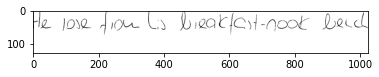

He rose from his breakfast - nook bench
He lose from his breakfast not bech 




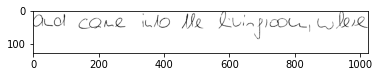

and came into the livingroom , where
and come into the livingion , where 




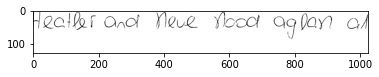

Heather and Steve stood aghast at
Heatler and Meve tod agpan at 




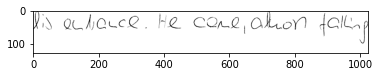

his entrance . He came , almost falling
his entrance . He cone , ahor faling 




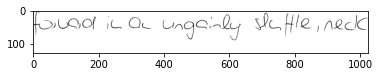

forward in an ungainly shuffle , neck
foward in On ungainly slufle , necl 




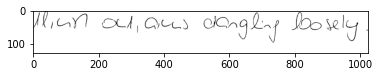

thrust out , arms dangling loosely .
1linst act , acus dongling losely . 




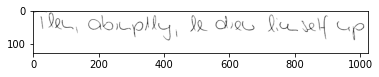

Then , abruptly , he drew himself up
Then , domptly , be dew limself up 




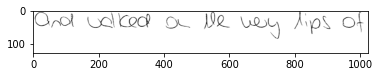

and walked on the very tips of
and valked on We very lips of 




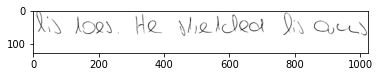

his toes . He stretched his arms
his loes . He shelcled Sis ay 




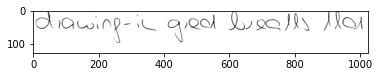

drawing - in great breaths that
drawing - in gret beals 1hal 



In [12]:
from data_source import preproc as pp
from matplotlib import pyplot as plt

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=gen.next_test_batch(),
                            steps=gen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [gen.tokenizer.decode(x[0]) for x in predicts]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(FilePaths.output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, gen.dataset['test']['gt']):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

for i, item in enumerate(gen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    plt.imshow(pp.adjust_to_see(item), cmap = "gray", vmin=0, vmax=255)
    plt.show()
    print(gen.dataset['test']['gt'][i])
    print(predicts[i], "\n")

### 7. Get a Evaluation on the Testset-Predictions 

In [13]:
%run Evaluate.ipynb

evaluate = calculate_error(predicts=predicts,
                                  ground_truth=gen.dataset['test']['gt'])

e_corpus = "\n".join([
    f"Total test images:    {gen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / gen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(FilePaths.output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)
    

Total test images:    1425
Total time:           0:00:52.290731
Time per item:        0:00:00.036695

Metrics:
Character Error Rate: 0.08032515
Word Error Rate:      0.25684745
Sequence Error Rate:  0.90877193


# 8. Visualizing the Model(CNN-Layers)

### 8.1 Get a Prediction on a self-written Test-Image:

Model Predict
1/1 [==============================] - 2s 2s/sample
CTC Decode
1/1 [==============================] - 0s 24ms/step


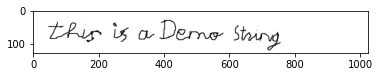

['thir is a Domo sting']


In [14]:
test_image = []
test_image.append(pp.preprocess(FilePaths.test_image_path, input_size=input_size))
test_image = pp.normalization(test_image)

prediction, _= model.predict(test_image, verbose=1, ctc_decode=True)
plt.imshow(pp.adjust_to_see(test_image[0]), cmap ="gray")
plt.show()
prediction = [gen.tokenizer.decode(x[0]) for x in prediction]

print(prediction)

### 8.2 Show and save the preprocessing:

True

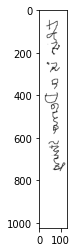

In [15]:
import cv2

preprocessed_img = pp.preprocess(FilePaths.test_image_path, input_size=(1024, 128, 1))
plt.imshow(preprocessed_img, cmap = "gray", vmin=0, vmax=255)
cv2.imwrite(FilePaths.test_image_preprocessed_path, preprocessed_img)

### 8.3 Show and save the weights of the first two CNN-Layers:

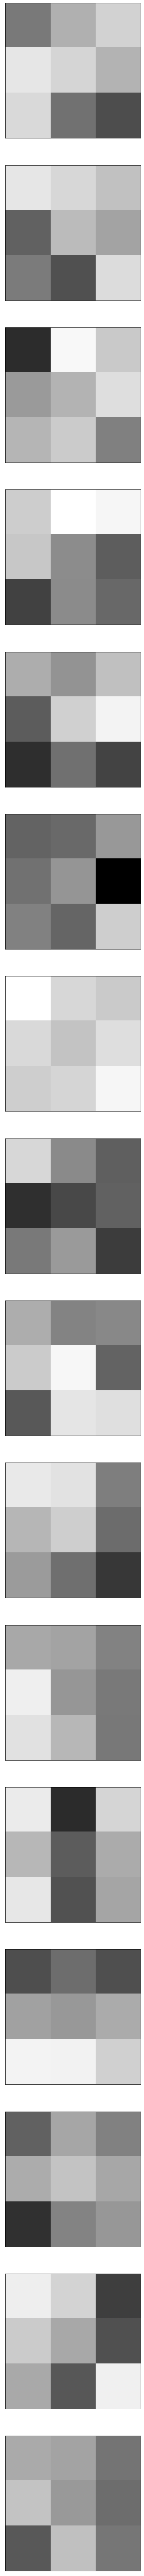

In [16]:
filters, biases = model.model.layers[1].get_weights()

plt.subplots(figsize=(50, 100))

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 16, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 1, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray', vmin = 0, vmax=1)
        ix += 1
# show the figure
plt.savefig(FilePaths.cnn_1_weights_path)
plt.show()

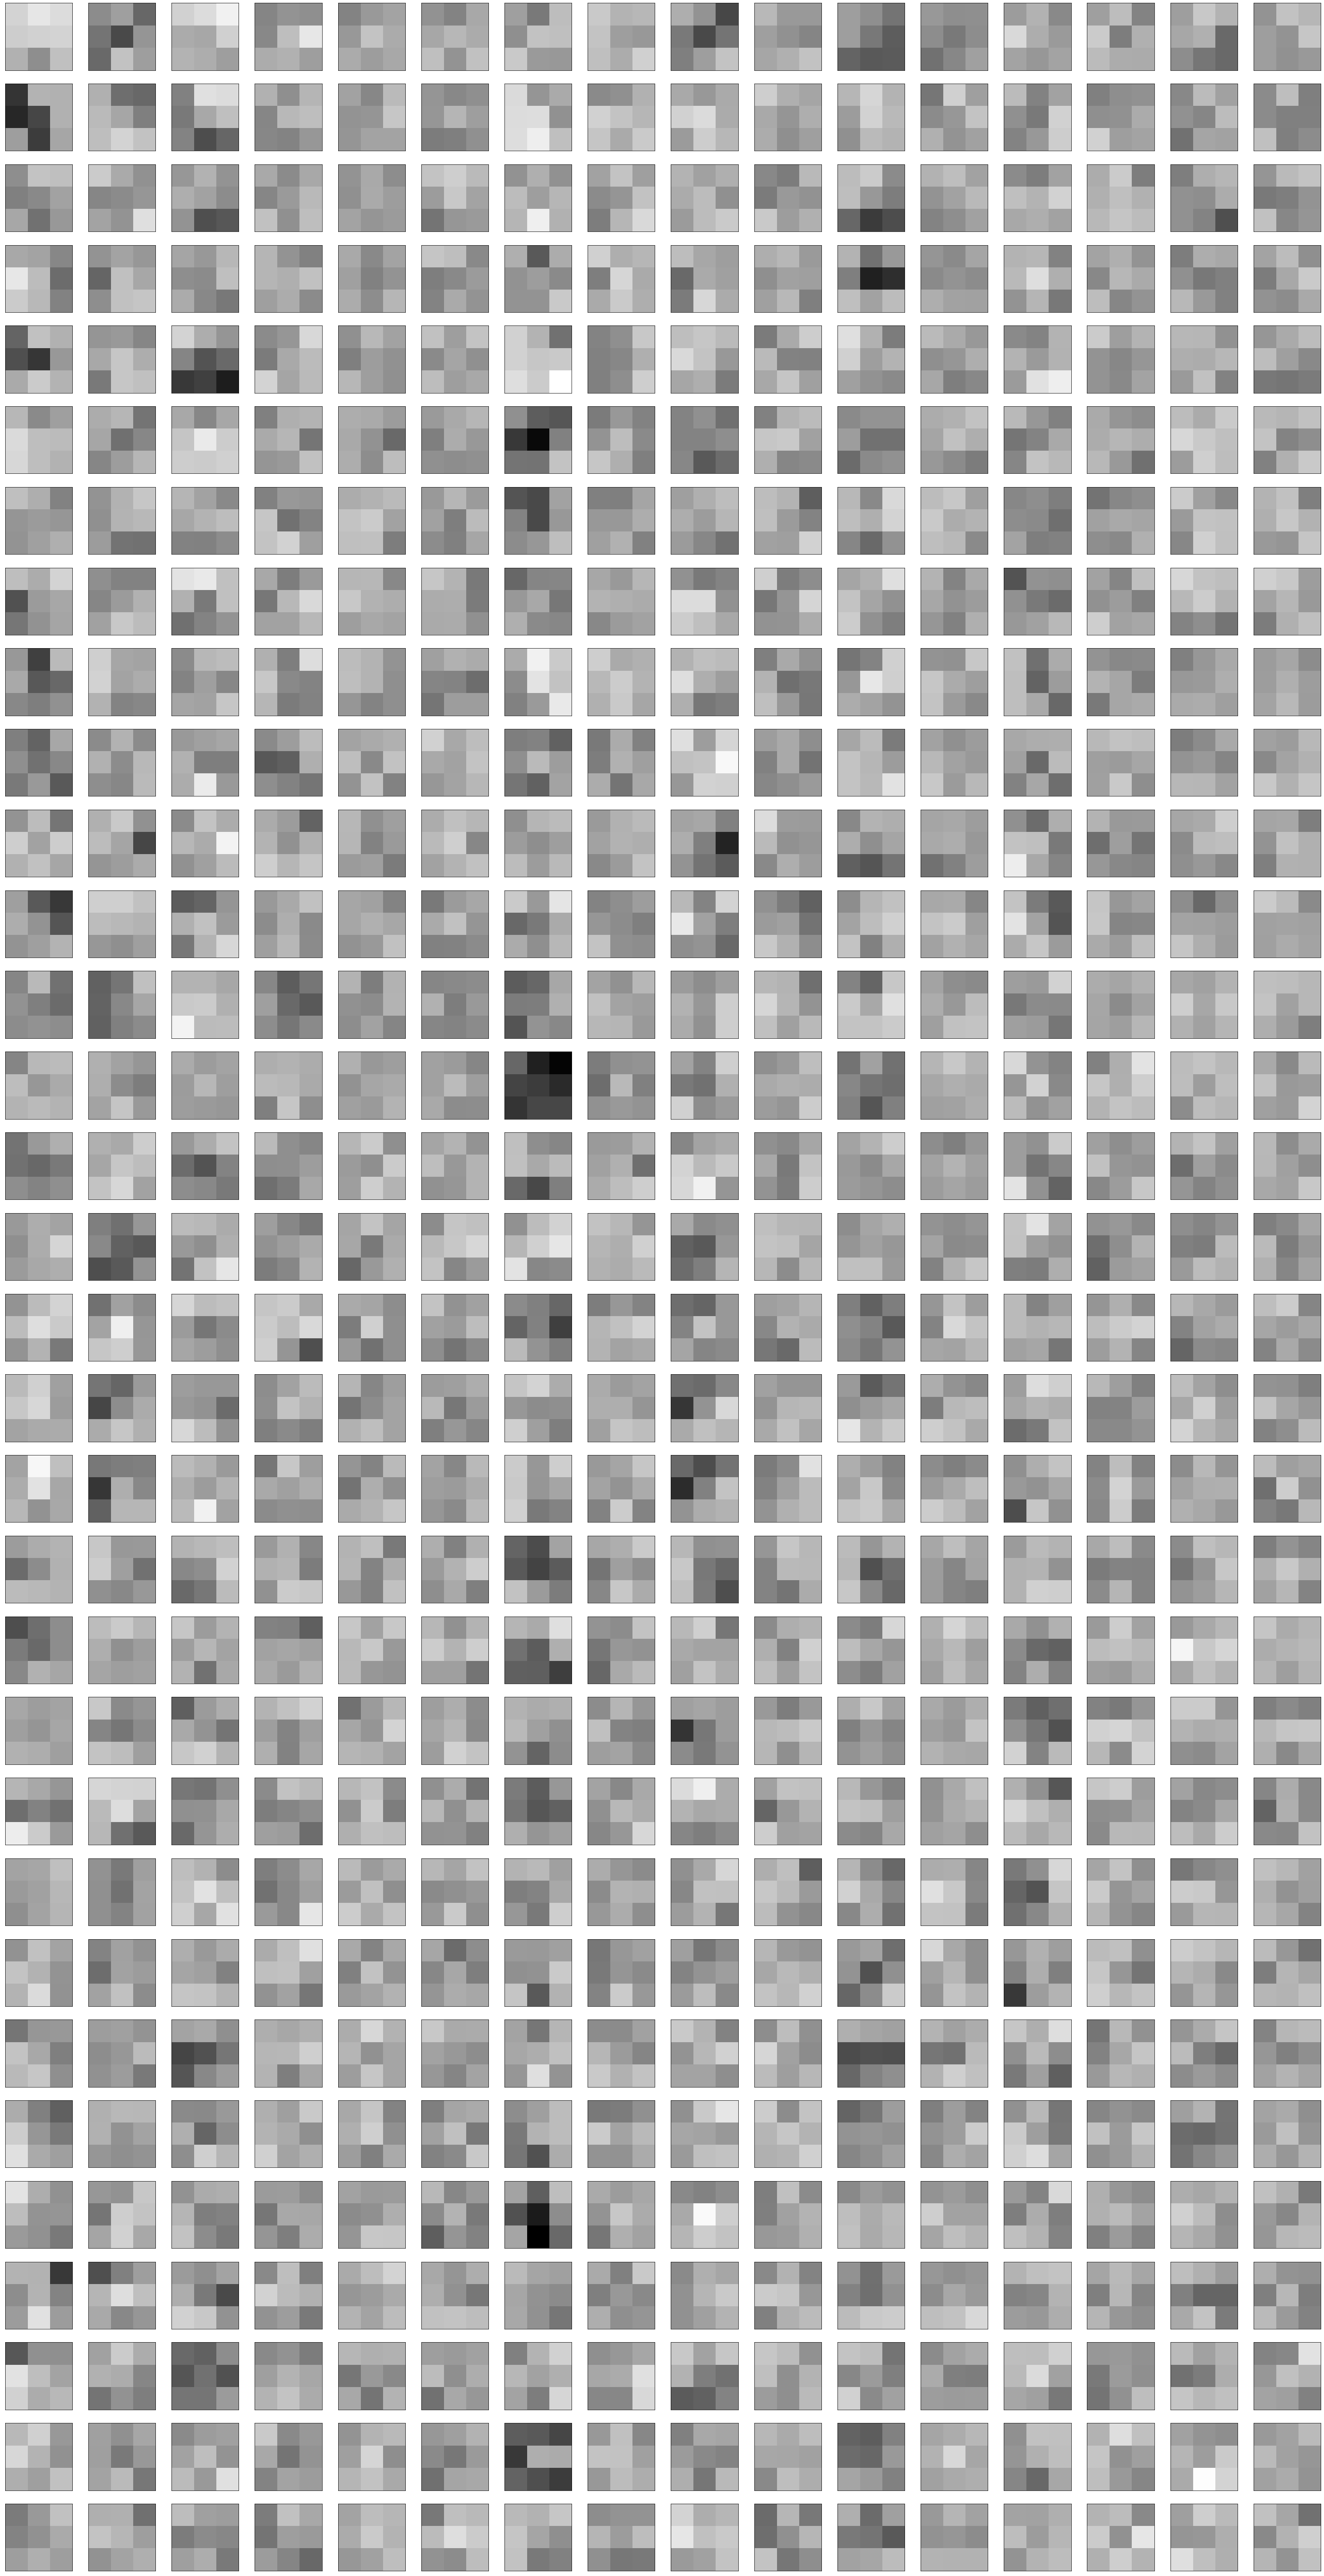

In [17]:
filters, biases = model.model.layers[5].get_weights()

plt.subplots(figsize=(50, 100))

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 32, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(16):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 16, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray', vmin = 0, vmax=1)
        ix += 1
# show the figure
plt.savefig(FilePaths.cnn_2_weights_path)
plt.show()

### 8.4 Visualize and save the outputs of each CNN-Layer:

In [18]:
cnn_1 = Model(model.model.inputs, model.model.layers[4].output)
cnn_2 = Model(model.model.inputs, model.model.layers[8].output)
cnn_3 = Model(model.model.inputs, model.model.layers[13].output)
cnn_4 = Model(model.model.inputs, model.model.layers[17].output)
cnn_5 = Model(model.model.inputs, model.model.layers[21].output)

In [19]:

output_cnn_1 = cnn_1.predict(x=test_image,verbose=1)
output_cnn_2 = cnn_2.predict(x=test_image,verbose=1)
output_cnn_3 = cnn_3.predict(x=test_image,verbose=1)
output_cnn_4 = cnn_4.predict(x=test_image,verbose=1)
output_cnn_5 = cnn_5.predict(x=test_image,verbose=1)

print(output_cnn_1.shape)
print(output_cnn_2.shape)
print(output_cnn_3.shape)
print(output_cnn_4.shape)
print(output_cnn_5.shape)


1/1 [==============================] - 0s 68ms/sample
(1, 512, 64, 16)
(1, 256, 32, 32)
(1, 128, 16, 48)
(1, 128, 16, 64)
(1, 128, 16, 80)


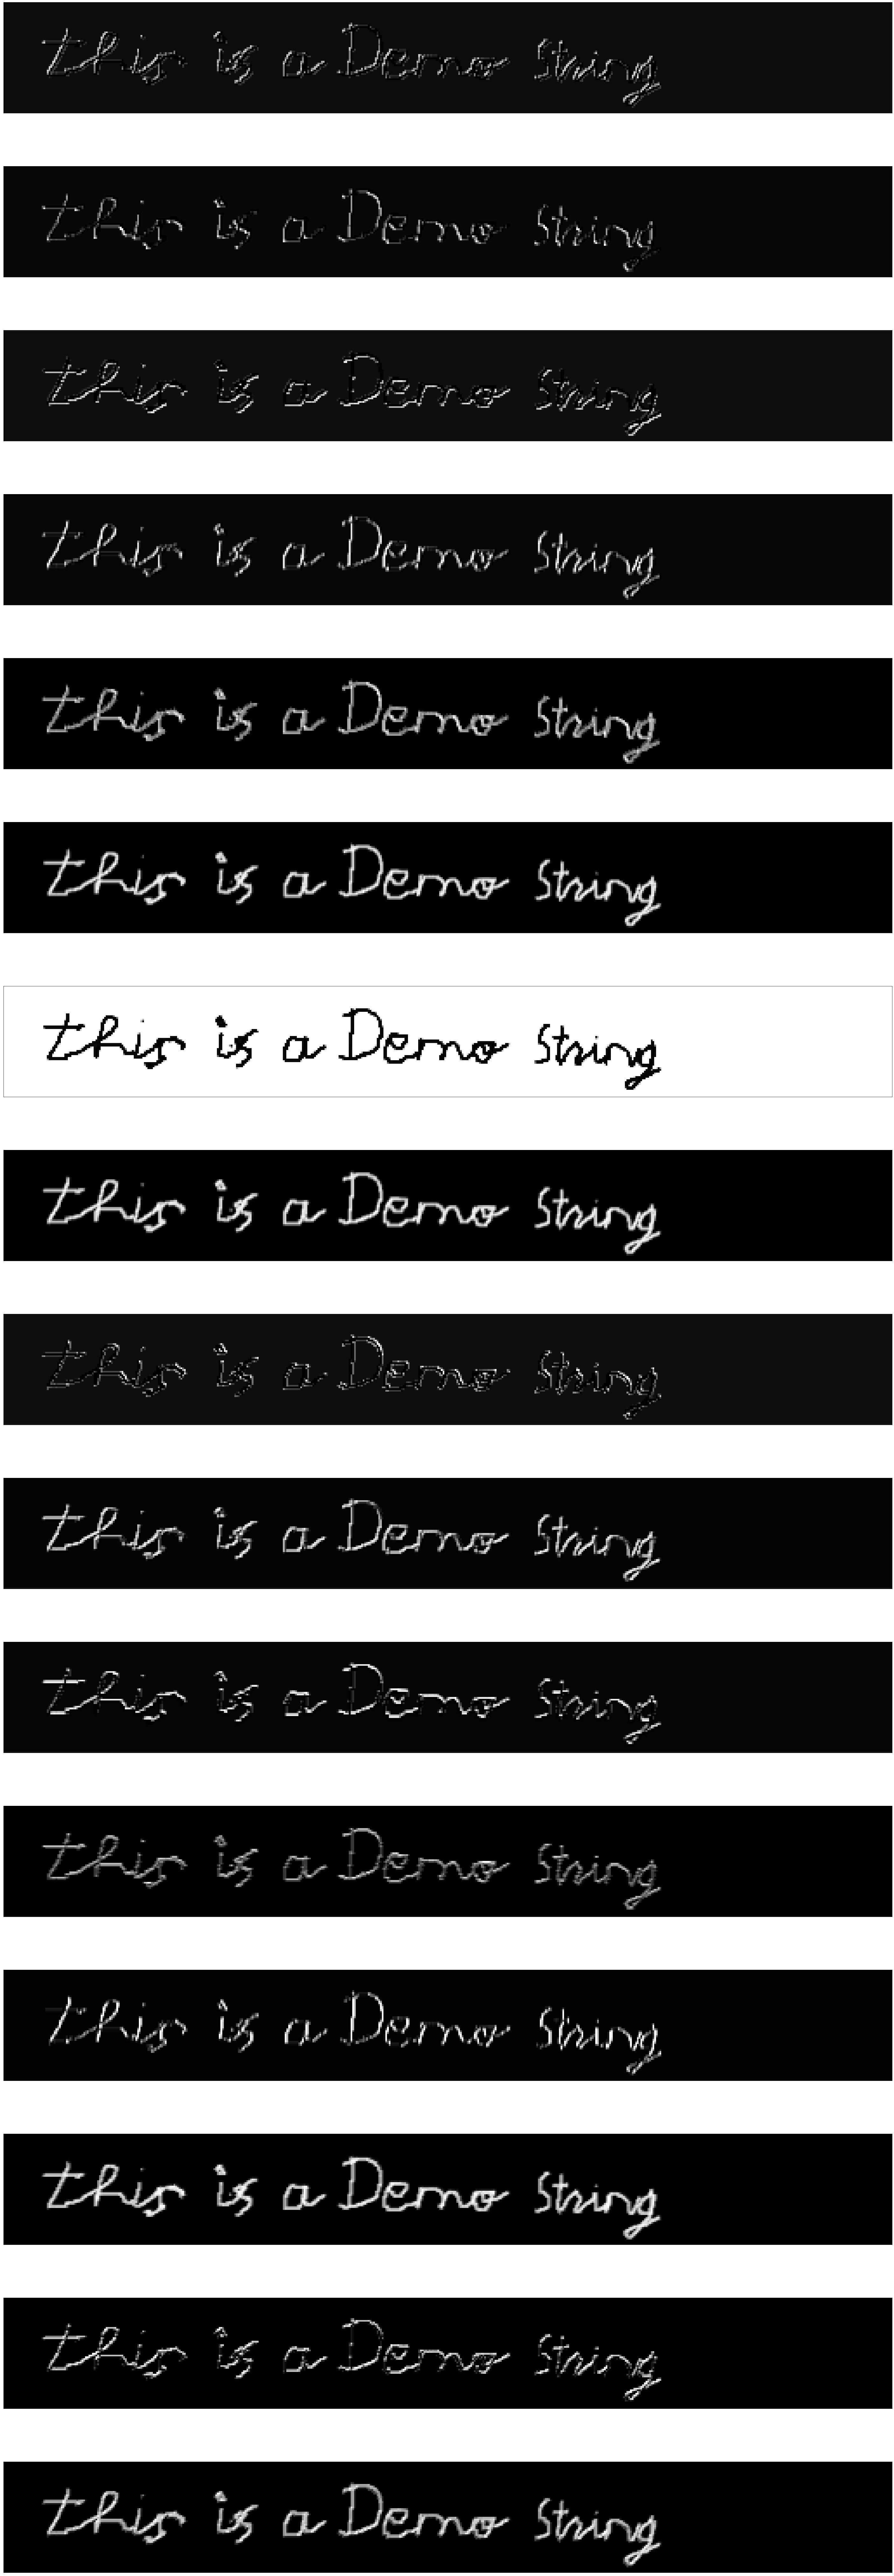

In [20]:
%matplotlib inline
from matplotlib.colors import Normalize

plt.subplots(figsize=(50, 150))
n_filters, ix = 16, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_1[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_1_outputs)
plt.show()
    

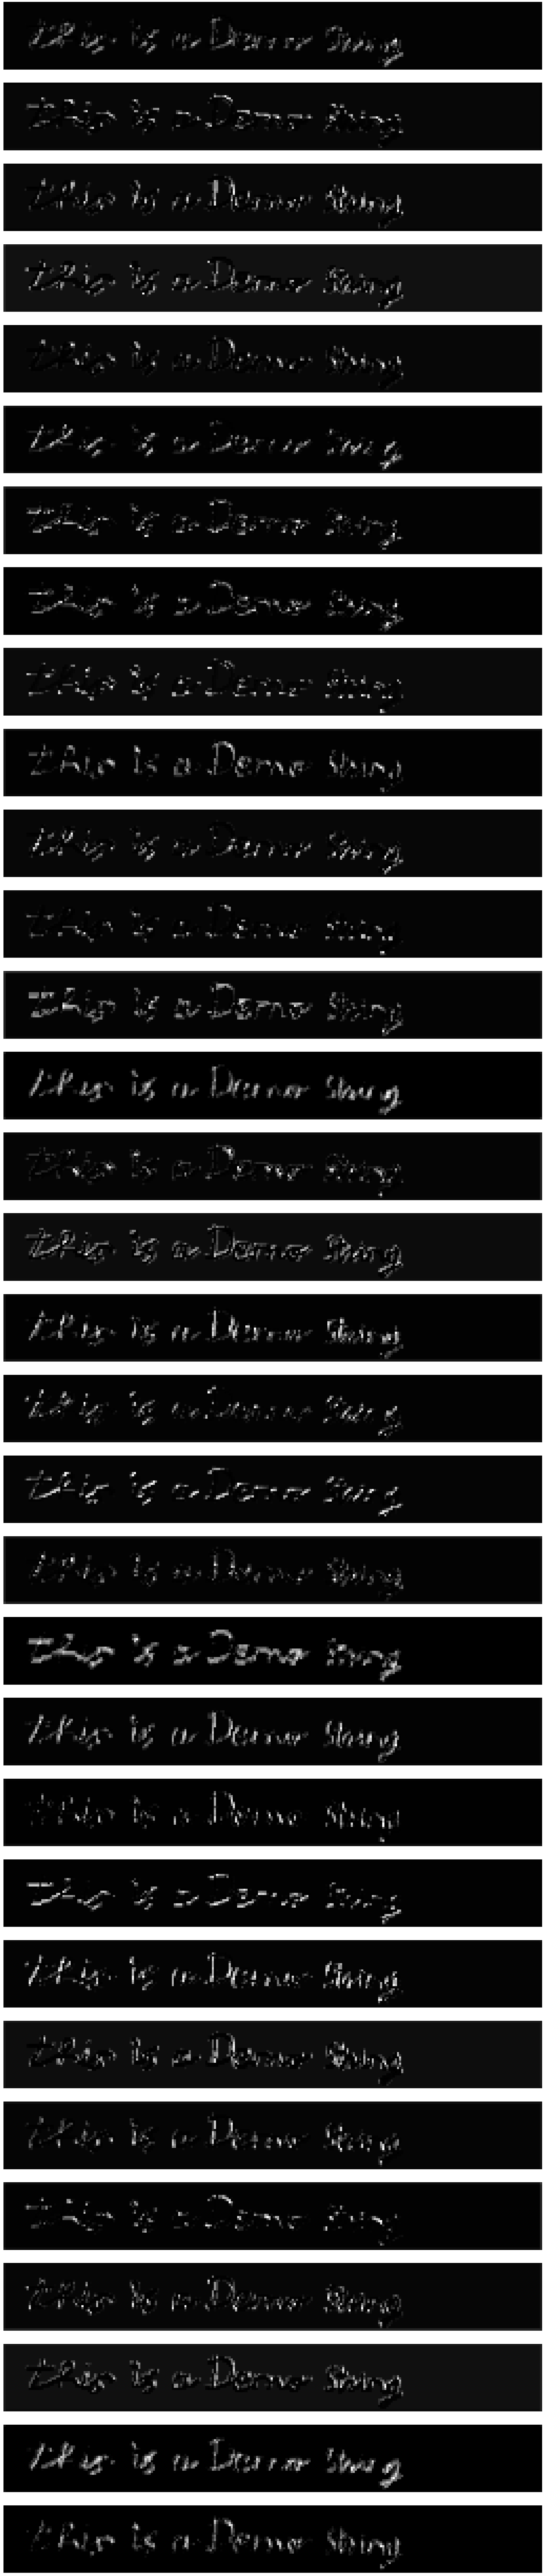

In [21]:
plt.subplots(figsize=(50, 150))
n_filters, ix = 32, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_2[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_2_outputs)
plt.show()

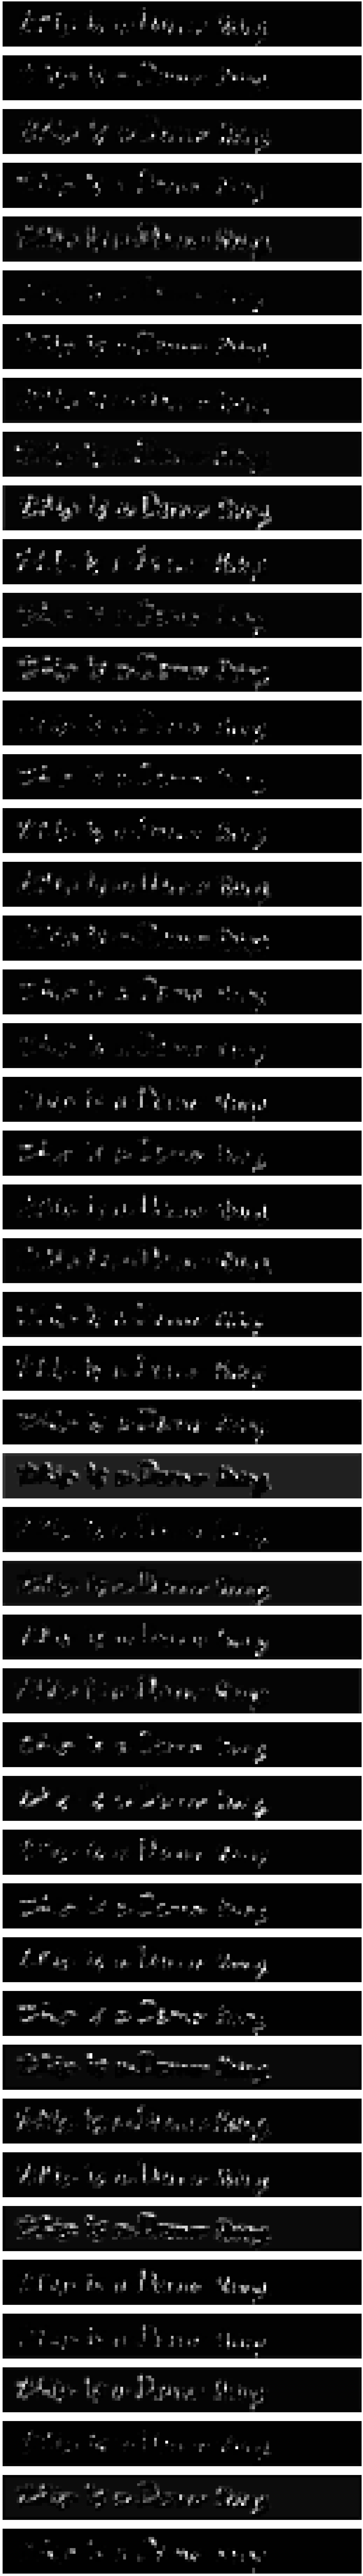

In [22]:
plt.subplots(figsize=(50, 200))
n_filters, ix = 48, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_3[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_3_outputs)
plt.show()

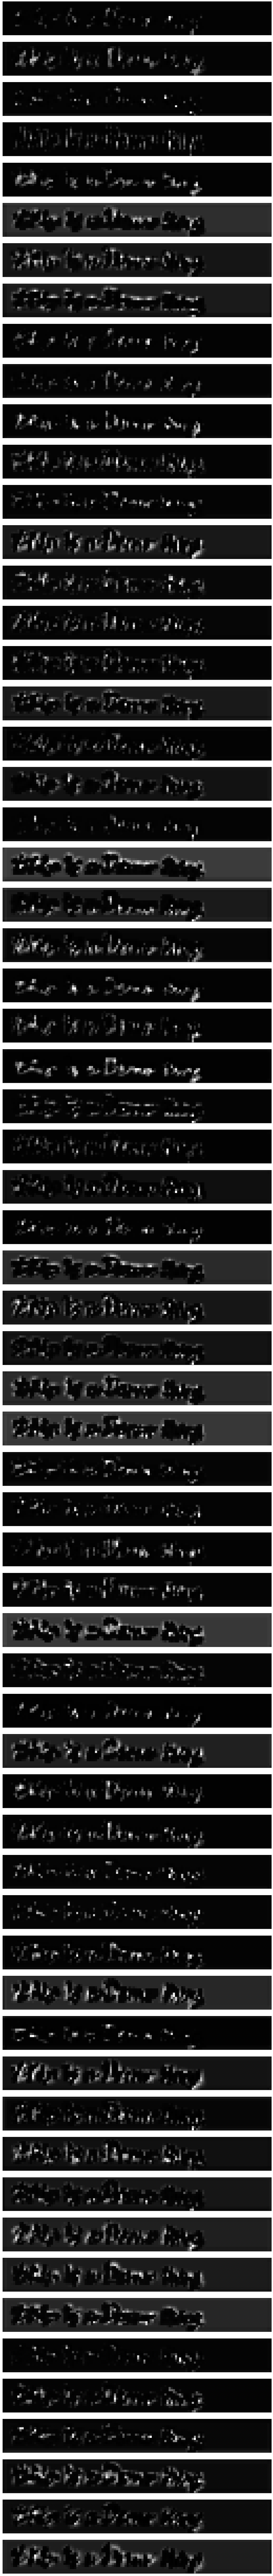

In [23]:
plt.subplots(figsize=(50, 200))
n_filters, ix = 64, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_4[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_4_outputs)
plt.show()

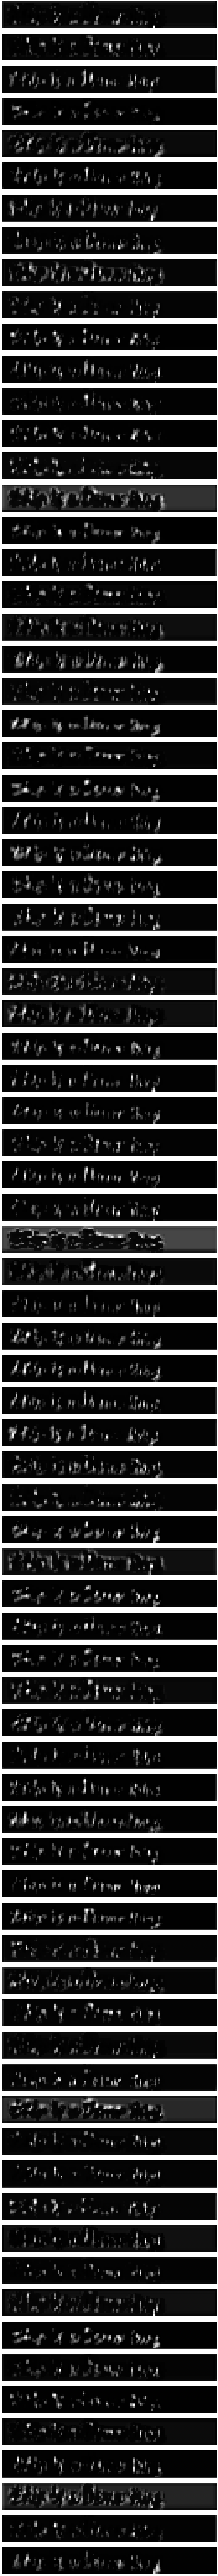

In [24]:
plt.subplots(figsize=(50, 250))
n_filters, ix = 80, 1
for i in range(n_filters):
    ax = plt.subplot(n_filters, 1, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(pp.adjust_to_see(output_cnn_5[0,:,:,i]), cmap="gray", aspect= "equal")
    ix += 1
    
plt.savefig(FilePaths.cnn_5_outputs)
plt.show()